# profile likelihood scans on the Asimov dataset

In this notebook we will:

   * generate the Asimov dataset
   * carry out likelihood scans for a number of nuisance parameters while minimizing the NLL w.r.t. all other nuisance parameters
   
This first part is based of `w_br_asimov.ipynb`.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from tqdm import tqdm_notebook

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 55499,
  "iopub_port": 47267,
  "stdin_port": 49637,
  "control_port": 59005,
  "hb_port": 42893,
  "ip": "127.0.0.1",
  "key": "66d4485f-41cfd3d742fa4592a862d09c",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-21ef7460-afce-40cb-ab29-2b97a73c10b2.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
input_dir  = f'local_data/templates/test_zjets_shape/'
selections = [
              'emu', 
              'mumu',  'mutau',  'mu4j',
              'ee',  'etau', 'e4j'
             ]
n_selection = len(selections)
targets    = dict(
                  mumu  = 'lepton2_pt', 
                  ee    = 'lepton2_pt', 
                  emu   = 'trailing_lepton_pt', 
                  mutau = 'lepton2_pt', 
                  etau  = 'lepton2_pt', 
                  mu4j  = 'lepton1_pt',
                  e4j   = 'lepton1_pt'
                 )
plot_labels = dict(
                   mumu  = [r'$\sf p_{T, \mu}$', r'$\mu\mu$'],
                   ee    = [r'$\sf p_{T, e}$', r'$ee$'],
                   emu   = [r'$\sf p_{T, \ell}$', r'$e\mu$'],
                   mutau = [r'$\sf p_{T, \tau}$', r'$\mu\tau$'],
                   etau  = [r'$\sf p_{T, \tau}$', r'$e\tau$'],
                   mu4j  = [r'$\sf p_{T, \mu}$', r'$\mu$ + jets'],
                   e4j   = [r'$\sf p_{T, e}$', r'$e$ + jets']
                  )

# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h) and tau branching fraction (b_e, b_mu, b_h)
br_tau    = [0.1783, 0.1741, 0.6476]
beta_init = [0.108, 0.108, 0.108, 1 - 3*0.108] 
var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]

# initialize fit data
fit_data = fh.FitData(input_dir, selections, targets)

In [3]:
# generate Asimov dataset
toy_data = dict()
for selection in selections:
    toy_data[selection] = dict()
    sdata = fit_data.get_selection_data(selection)
    for category, bdata in sdata.items():
        
        templates = bdata['templates']
        # signal component
        toy_data[selection][category] = np.zeros(bdata['bins'].size - 1)
        for dataset, template in templates.items():
            if dataset in['ttbar', 't', 'wjets']: 
                signal_template = pd.DataFrame.from_items((dm, t['val']) for dm, t in template.items())
                signal = fh.signal_mixture_model(beta_init, br_tau, signal_template, sample=False, single_w=(dataset == 'wjets'))
                toy_data[selection][category] += signal
            elif dataset != 'data':
                toy_data[selection][category] += template['val']

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  del sys.path[0]


In [4]:
# configuration for likelihood scans 

def reduced_objective(obj, p, mask, p_init):
    '''
    Fixes parameters specified by (p, mask) and minimizes objective w.r.t. remaining parameters.
    '''
    masked_p = p_init.copy()
    masked_p[mask] = p
    return fit_data.objective(masked_p, data=toy_data, cost_type=cost_type, no_shape=False)

params_init = fit_data.get_params_init().values
cost_type = 'poisson'
nscan_points = 14
param = fit_data._parameters.loc['lumi']
ix = 4

pmin, pmax = param.val_init-param.err_init, param.val_init+param.err_init
scan_points = np.vstack([params_init for _ in range(nscan_points+1)])
scan_points[:,ix] = np.sort(np.append(np.linspace(pmin, pmax, num=nscan_points), params_init[ix]))

mask = np.zeros(len(params_init)).astype(bool)
mask[ix] = True

In [6]:
# carry out one-dimensional profile likelihood scans
from multiprocessing import Pool
pool = Pool(processes=12)
results = []
for sp in scan_points:
    fobj = partial(reduced_objective, p=sp[ix], mask=mask, p_init=params_init)
    p = np.delete(params_init, ix)
    #res = pool.apply_async(minimize, args=(fobj, p), kwds={'method':'BFGS', 'jac':False, 'hess':False})
    res = pool.apply_async(minimize, args=(fobj, p), kwds={'method':'BFGS'})
    results.append(res)
    
pool.close()
pool.join()

print('All done!!!')

results = [r.get() for r in results]
nll_scan = [r.fun for r in results]

All done!!!


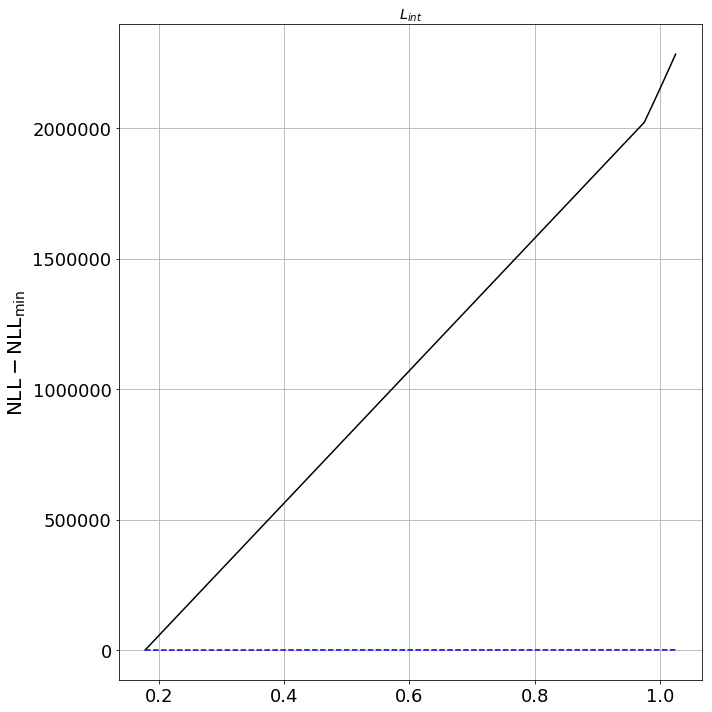

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white', sharey=False)

ax.plot(scan_points[:,ix], nll_scan-np.min(nll_scan), 'k-', linewidth=1.5)
ax.plot(scan_points[:,ix], 0.5*(params_init[ix] - scan_points[:,ix])**2/param.err_init**2, 'b--', linewidth=1.5)
#ax.plot([nll_scan[0, 0], nll_scan[-1, 0]], [0., 0.], 'r-', linewidth=1.5)
ax.set_title(param.label)
#ax.set_xlim(-0.1, 0.1)
#ax.set_ylim(-0.1, 100)
ax.set_ylabel('$\sf NLL - NLL_{min}$')
ax.grid()

plt.tight_layout()
plt.show()